In [1]:
from IPython.display import Image

<h1 align=center>Redes Adversariais Geradoras para Sintetizar Novos Dados</h1>

<p align=center><img src=https://advancedinstitute.ai/wp-content/uploads/2020/08/real_fake.png width=500></p>

Anteriomente, focamos em redes neurais recorrentes (RNN) para modelagem de sequências. Aqui, exploraremos as redes generativas de adversários (GANs) e veremos sua aplicação na síntese de novas amostras de dados. As GANs são consideradas o avanço mais importante no aprendizado profundo, permitindo que os computadores gerem novos dados (como novas imagens).

Aqui, abordaremos os seguintes tópicos:
* Apresentando modelos generativos para sintetizar novos dados
* Autoencoders, autoencoders variacionais (VAEs) e seu relacionamento com GANs
* Entendendo os blocos de construção das GANs
* Implementação de um modelo GAN simples para gerar dígitos manuscritos
* Noções básicas sobre convolução transposta e normalização de lote (BatchNorm ou BN)
* Melhorar GANs: GANs convolucionais profundos e GANs usando a distância de *Wasserstein*

## Apresentando redes adversárias generativas
Vamos primeiro olhar para os fundamentos dos modelos GAN. O objetivo geral de uma GAN é <u>sintetizar novos dados que tenham a mesma distribuição que seu conjunto de dados de treinamento</u>. Portanto, as GANs, em sua forma original, são consideradas na categoria de aprendizado não supervisionado de tarefas de aprendizado de máquina, pois não são necessários dados rotulados. Vale a pena notar, no entanto, que as extensões feitas ao GAN original podem estar em tarefas semi-supervisionadas e supervisionadas.

O conceito geral de GAN foi proposto pela primeira vez em 2014 por Ian Goodfellow e seus colegas como um método para sintetizar novas imagens usando redes neurais profundas (NNs). Embora a arquitetura GAN inicial proposta fosse baseada em camadas totalmente conectadas, semelhantes às arquiteturas *perceptron* multicamadas, e treinadas para gerar dígitos manuscritos de baixa resolução do tipo MNIST, ela serviu mais como uma prova de conceito para demonstrar a viabilidade dessa nova abordagem.

No entanto, desde sua introdução, os autores originais, assim como muitos outros pesquisadores, propuseram inúmeras melhorias e diversas aplicações em diferentes campos da engenharia e da ciência; por exemplo, em visão computacional, GANs são usadas ​​para tradução de imagem para imagem (aprender a mapear uma imagem de entrada para uma imagem de saída), super-resolução de imagem (criar uma imagem de alta resolução a partir de uma versão de baixa resolução), pintura interna de imagem (aprender a reconstruir as partes que faltam de uma imagem) e muitas outras aplicações. Por exemplo, os avanços recentes na pesquisa de GAN levaram a modelos capazes de gerar novas imagens de rosto de alta resolução. Exemplos dessas imagens de alta resolução podem ser encontrados em https://www.thispersondoesnotexist.com/, que mostra imagens de rosto sintéticas geradas por uma GAN.

### Começando com os *autoencoders*
Antes de discutirmos como as GANs funcionam, começaremos com os *autoencoders*, que podem compactar e descompactar dados de treinamento. Embora os codificadores automáticos padrão não possam gerar novos dados, entender sua função ajudará você a navegar pelas GANs na próxima seção.

Autoencoders são compostos por duas redes concatenadas: uma rede codificadora e uma rede decodificadora. A rede codificadora recebe um vetor de recurso de entrada *d*-dimensional associado ao exemplo **x** (ou seja, ***x*** $\small \in R^p$) e o codifica em um vetor *p*-dimensional, `z` (ou seja, ***z*** $\small \in R^p$). Em outras palavras, o papel do codificador é aprender a modelar a função ***z*** = $\small f(x)$ . O vetor codificado, `z`, também é chamado de vetor latente ou representação de característica latente. Normalmente, a dimensionalidade do vetor latente é menor que a dos exemplos de entrada; em outras palavras, $\small p < d$. Assim, podemos dizer que o codificador atua como uma função de compressão de dados. Então, o decodificador descomprime $\small \hat{x}$ do vetor latente de menor dimensão, `z`, onde podemos pensar no decodificador como uma função, $\small \hat{x} = g(z)$. Uma arquitetura simples de *autoencoder* é mostrada na figura a seguir, onde as partes do codificador e do decodificador consistem em apenas uma camada totalmente conectada cada:

![](imagens\autoencoder.PNG)

> ##### A conexão entre autoencoders e redução de dimensionalidade
> Certamente você já aprendeu sobre técnicas de redução de dimensionalidade, como análise de componentes principais (PCA) e análise discriminante linear (LDA). *Autoencoders* também podem ser usados como uma **técnica de redução de dimensionalidade**. De fato, quando não há não linearidade em nenhuma das duas sub-redes (codificador e decodificador), a abordagem do autoencoder é quase idêntica ao PCA.
>
> Nesse caso, se assumirmos que os pesos de um codificador de camada única (sem camada oculta e sem função de ativação não linear) são denotados pela matriz **U**, então os modelos do codificador **z** = $\small U^Tx$. Da mesma forma, um decodificador linear de camada única modela $\small \hat{x} = Uz$. Juntando esses dois componentes, temos $\small \hat{x} = UU^Tx$. Isso é exatamente o que o PCA faz, com a exceção de que o PCA tem uma restrição ortonormal adicional: $\small UU^T = I_{n \times n}$. 

Embora a figura anterior represente um *autoencoder* sem camadas ocultas dentro do codificador e do decodificador, podemos, é claro, adicionar várias camadas ocultas com não linearidades (como em uma NN multicamada) para construir um *autoencoder* profundo que pode aprender funções de reconstrução e compactação de dados mais eficazes. Além disso, observe que o *autoencoder* mencionado nesta seção usa camadas totalmente conectadas. Quando trabalhamos com imagens, no entanto, podemos substituir as camadas totalmente conectadas por camadas convolucionais.

> ##### Outros tipos de autoencoders baseados no tamanho do espaço latente
> Como mencionado anteriormente, a dimensionalidade do espaço latente de um *autoencoder* é tipicamente menor que a dimensionalidade das entradas ($\small p < d$), o que torna os autoencoders adequados para redução de dimensionalidade. Por esse motivo, o vetor latente também é frequentemente chamado de "gargalo", e essa configuração específica de um *autoencoder* também é chamada de `undercomplete` (subcompleto). No entanto, existe uma categoria diferente de *autoencoders*, chamada `overcomplete`, onde a dimensionalidade do vetor latente, `z`, é, de fato, maior que a dimensionalidade dos exemplos de entrada ($\small p > d$).

Ao treinar um *autoencoder* `overcomplete` (supercompleto), há uma solução trivial em que o codificador e o decodificador podem simplesmente aprender a copiar (memorizar) os recursos de entrada para sua camada de saída. Obviamente, esta solução não é muito útil. No entanto, com algumas modificações no procedimento de treinamento, os *autoencoders* supercompletos podem ser usados **​​para redução de ruído**. Nesse caso, durante o treinamento, o ruído aleatório, $\epsilon$, é adicionado aos exemplos de entrada e a rede aprende a reconstruir o exemplo, `x`, do sinal ruidoso, $\small x + \epsilon$. Então, no momento da avaliação, fornecemos os novos exemplos que são naturalmente ruidosos (ou seja, o ruído já está presente de modo que nenhum ruído artificial adicional, $\epsilon$, é adicionado) para remover o ruído existente desses exemplos. Essa arquitetura de *autoencoder* e o método de treinamento específicos são chamados de *autoencoder* de redução de ruído.

### Modelos generativos para sintetizar novos dados

Autoencoders são modelos determinísticos, o que significa que depois que um autoencoder é treinado, dada uma entrada, **x**, ele será capaz de reconstruir a entrada de sua versão compactada em um espaço de menor dimensão. Portanto, ele não pode gerar novos dados além de reconstruir sua entrada por meio da transformação da representação compactada.

Um modelo generativo, por outro lado, pode gerar um novo exemplo, $\small \tilde{x}$ , a partir de um vetor aleatório, **z** (correspondente à representação latente). Uma representação esquemática de um modelo generativo é mostrada na figura a seguir. O vetor aleatório, **z**, vem de uma distribuição simples com características totalmente conhecidas, então podemos facilmente amostrar de tal distribuição. Por exemplo, cada elemento de **z** pode vir da distribuição uniforme no intervalo [–1, 1] (para a qual escrevemos $\small z_i \sim \: Uniform(-1,1)$ ou de uma distribuição normal padrão (nesse caso, escrevemos $\small z_i \sim \: Normal (\mu = 0, \sigma^2=1)$).

<p><img src =imagens\generative_model.PNG></p>


À medida que mudamos nossa atenção de autoencoders para modelos generativos, você deve ter notado que o componente decodificador de um *autoencoder* tem algumas semelhanças com um modelo generativo. Em particular, ambos recebem um vetor latente, **z**, como entrada e retornam uma saída no mesmo espaço que **x**. (Para o *autoencoder*, $\small \hat{x}$ é a reconstrução de uma entrada, **x**, e para o modelo generativo, $\small \tilde{x}$ é uma amostra sintetizada.)

No entanto, a principal diferença entre os dois é que não conhecemos a distribuição de **z** no *autoencoder*, enquanto em um modelo generativo, a distribuição de **z** é totalmente caracterizável. No entanto, é possível generalizar um *autoencoder* em um modelo generativo. Uma abordagem são os **VAEs**. Em um VAE que recebe um exemplo de entrada, **x**, a rede do codificador é modificada de tal forma que computa dois momentos da distribuição do vetor latente: a média, $\small \mu$, e a variância, $\small \sigma^2$. Durante o treinamento de um VAE, a rede é forçada a combinar esses momentos com os de uma distribuição normal padrão (ou seja, **média zero e variância unitária**). Então, depois que o modelo VAE é treinado, o codificador é descartado e podemos usar a rede do decodificador para gerar novos exemplos, $\small \tilde{x}$, alimentando vetores **z** aleatórios da distribuição gaussiana "aprendida". Além dos VAEs, existem outros tipos de modelos generativos, por exemplo, modelos autorregressivos e modelos de fluxo normalizador. No entanto, vamos nos concentrar apenas nos modelos GAN, que estão entre os tipos mais recentes e populares de modelos generativos em deep learning.


> ##### O que é um modelo generativo?
> Observe que os modelos generativos são tradicionalmente definidos como algoritmos que modelam as distribuições de entrada de dados, $\small p(x)$, ou as distribuições conjuntas dos dados de entrada e alvos associados, $\small p(x, y)$. Por definição, esses modelos também são capazes de amostrar de algum recurso, $\small x_i$, condicionado a outro recurso, $\small x_j$, conhecido como **inferência condicional**. No contexto de aprendizado profundo, no entanto, o termo **modelo generativo** é normalmente usado para se referir a modelos que geram dados de aparência realista. Isso significa que podemos amostrar a partir de distribuições de entrada, $\small p(x)$, mas não somos necessariamente capazes de realizar inferência condicional.

### Gerando novas amostras com GANs
Para entender o que as GANs fazem em poucas palavras, vamos primeiro supor que temos uma rede que recebe um vetor aleatório, **z**, amostrado de uma distribuição conhecida e gera uma imagem de saída, **x**. Chamaremos esse **gerador de rede** (G) e usaremos a notação $\small \tilde{x} = G(z)$ para nos referirmos à saída gerada. Suponha que nosso objetivo seja gerar algumas imagens, por exemplo, imagens de rostos, imagens de prédios, imagens de animais ou até mesmo dígitos manuscritos como o MNIST.

Como sempre, inicializaremos essa rede com pesos aleatórios. Portanto, as primeiras imagens de saída, antes que esses pesos sejam ajustados, parecerão ruído branco. Agora, imagine que existe uma função que pode avaliar a qualidade das imagens (vamos chamá-la de **função avaliadora**).

Se tal função existir, podemos usar o feedback dessa função para informar à nossa rede geradora como ajustar seus pesos para melhorar a qualidade das imagens geradas. Dessa forma, podemos treinar o gerador com base no feedback dessa função avaliadora, de modo que o gerador aprenda a melhorar sua saída para produzir imagens de aparência realista.

Enquanto uma função de avaliador, conforme descrito no parágrafo anterior, facilitaria muito a tarefa de geração de imagens, a questão é se existe uma função tão universal para avaliar a qualidade das imagens e, em caso afirmativo, como ela é definida. Obviamente, como humanos, podemos facilmente avaliar a qualidade das imagens de saída quando observamos as saídas da rede; embora não possamos (ainda) retropropagar o resultado do nosso cérebro para a rede. Agora, se nosso cérebro pode avaliar a qualidade das imagens sintetizadas, podemos projetar um modelo NN para fazer a mesma coisa? Na verdade, essa é a ideia geral de uma GAN. Conforme mostrado na figura a seguir, um modelo GAN consiste em uma NN adicional chamado **discriminador** (D), que é um classificador que aprende a detectar uma imagem sintetizada, $\small \tilde{x}$, a partir de uma imagem real, **x**:

<p><img src = imagens\gerador_discriminador.PNG></p>

Em um modelo GAN, as duas redes, geradora e discriminadora, são treinadas juntas. A princípio, após inicializar os pesos do modelo, o gerador cria imagens que não parecem realistas. Da mesma forma, o discriminador faz um trabalho ruim ao distinguir entre imagens reais e imagens sintetizadas pelo gerador. Mas com o tempo (ou seja, por meio de treinamento), ambas as redes se tornam melhores à medida que interagem entre si. De fato, as duas redes fazem um jogo de adversários, onde o gerador aprende a melhorar sua saída para poder enganar o discriminador. Ao mesmo tempo, o discriminador se torna melhor na detecção das imagens sintetizadas.



### Entendendo as funções de perda das redes geradoras e discriminadoras em um modelo GAN
A função objetivo das GANs, conforme descrito no artigo original Generative Adversarial Nets de Goodfellow et al. (https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), é o seguinte:

$$
\small V\left ( \theta ^{D}, \theta^{(G)} \right ) = E_{x \sim p_{data}(x))}[logD(x)] + E_{z\sim p_z(z))}\left [ log(1-D(G(z))) \right ]
$$

Aqui, $\small V\left ( \theta ^{D}, \theta^{(G)} \right )$ é chamada de *função valor*, que pode ser interpretada como uma recompensa: queremos maximizar seu valor em relação ao discriminador (D), enquanto minimizamos seu valor em relação a o gerador (G), ou seja, min $\small \underset{G}{min} \: \underset{D}{max} \: V(\theta^{(D)}, \theta^{(G)})$.
$D_{(x)}$ é a probabilidade que indica se o exemplo de entrada, **x**, é real ou falso (ou seja, gerado). A expressão $\small E_{x \sim p_{data}(x))}[logD(x)]$ refere-se ao valor esperado da quantidade entre parênteses em relação aos exemplos da distribuição de dados (distribuição dos exemplos reais); $\small E_{z\sim p_z(z))}\left [ log(1-D(G(z))) \right]$ refere-se ao valor esperado da quantidade em relação à distribuição dos vetores de entrada, **z**.

Uma etapa de treinamento de um modelo GAN com tal função de valor requer duas etapas de otimização: (1) maximizar o retorno para o discriminador e (2) minimizar o retorno para o gerador. Uma maneira prática de treinar GANs é alternar entre essas duas etapas de otimização: (1) corrigir (congelar) os parâmetros de uma rede e otimizar os pesos da outra e (2) corrigir a segunda rede e otimizar a primeira. Este processo deve ser repetido a cada iteração de treinamento. Vamos supor que a rede geradora seja fixa e queremos otimizar o discriminador. Ambos os termos da função valor $\small V\left ( \theta ^{D}, \theta^{(G)} \right )$ contribuem para otimizar o discriminador, onde o primeiro termo corresponde à perda associada aos exemplos reais, e o segundo termo é a perda aos exemplos falsos. Portanto, quando G é fixo, nosso objetivo é *maximizar* $\small V\left ( \theta ^{D}, \theta^{(G)} \right )$, o que significa tornar o discriminador melhor na distinção entre imagens reais e geradas.


Depois de otimizar o discriminador usando os termos de perda para amostras reais e falsas, corrigimos o discriminador e otimizamos o gerador. Neste caso, apenas o segundo termo em $\small V\left ( \theta ^{D}, \theta^{(G)} \right )$ contribui para os gradientes do gerador. Como resultado, quando *D* é fixo, nosso objetivo é *minimizar* $\small V\left ( \theta ^{D}, \theta^{(G)} \right )$ , que pode ser escrito como $\small \underset{G}{min}\:E_{z\sim p_z(z))}\left [ log(1-D(G(z))) \right]$. Como foi mencionado no artigo GAN original de Goodfellow et al., esta função, $\small log(1-D(G(z)))$, sofre de gradientes de fuga nos estágios iniciais de treinamento. A razão para isso é que as saídas, $\small G_{(z)}$, no início do processo de aprendizagem, não se parecem em nada com exemplos reais e, portanto, $\small D(G_{(z)})$ será próximo de zero com alta confiança. Esse fenômeno é chamado de **saturação**. Para resolver esse problema, podemos reformular o objetivo de minimização, $\small\underset{G}{min}\:E_{z\sim p_z(z))}\left [ log(1-D(G(z))) \right ]$,
reescrevendo-o como $\small \underset{G}{max}\:E_{z\sim p_z(z))}\left [ log(D(G(z))) \right ]$.





Essa substituição significa que para treinar o gerador, podemos trocar os rótulos de exemplos reais e falsos e realizar uma minimização regular da função. Em outras palavras, mesmo que os exemplos sintetizados pelo gerador sejam falsos e, portanto, rotulados como 0, podemos inverter os rótulos atribuindo o rótulo 1 a esses exemplos e minimizar a perda de entropia cruzada binária com esses novos rótulos em vez de maximizar $\small \underset{G}{max}\:E_{z\sim p_z(z))}\left [ log(D(G(z))) \right ]$.

Agora que abordamos o procedimento geral de otimização para treinar modelos de GAN, vamos explorar os vários rótulos de dados que podemos usar ao treinar GANs.
Dado que o discriminador é um classificador binário (os rótulos de classe são 0 e 1 para imagens falsas e reais, respectivamente), podemos usar a função de perda de entropia cruzada binária (*binary cross-entropy*). Portanto, podemos determinar os rótulos de verdade do terreno para a perda do discriminador da seguinte forma:

$$
\small
\text{R$\acute{o}$tulos verdadeiros para o discriminador} = 
\begin{cases}
1:  & \quad \text{para imagens reais, por exemplo,\:$\textbf{x}$}\\ 
0: & \quad \text{para sa$\acute{i}$das de G, por exemplo, G($\textbf{z}$)}
\end{cases}
$$

E as etiquetas para treinar o gerador? Como queremos que o gerador sintetize imagens realistas, queremos penalizar o gerador quando suas saídas não forem classificadas como reais pelo discriminador. Isso significa que assumiremos os rótulos verdadeiros para as saídas do gerador como 1 ao calcular a função de perda para o gerador.

Juntando tudo isso, a figura a seguir exibe as etapas individuais em um modelo GAN simples:

<p><img src= imagens\modelo_GAN.PNG></p>

Na seção a seguir, implementaremos um GAN do zero para gerar novos dígitos manuscritos.

### Implementando um GAN do zero

Nesta seção, abordaremos como implementar e treinar um modelo GAN para gerar novas imagens, como dígitos MNIST. Como o treinamento em uma unidade de processamento central (CPU) normal **pode levar muito tempo**, na subseção a seguir, abordaremos como configurar o ambiente **Google Colab**, que nos permitirá executar os cálculos em unidades de processamento gráfico (*GPUs*) .

### Treinamento de modelos GAN no *Google Colab*
Alguns dos exemplos de código podem exigir recursos computacionais extensivos que vão além de um laptop comercial ou uma estação de trabalho sem GPU. Se você já possui uma máquina de computação habilitada para GPU NVIDIA disponível, com bibliotecas CUDA e cuDNN instaladas, você pode usá-la para acelerar os cálculos.


No entanto, como muitos de nós não têm acesso a recursos de computação de alto desempenho, usaremos o ambiente *Google Colaboratory* (muitas vezes referido como *Google Colab*), que é um serviço gratuito de computação em nuvem (disponível na maioria dos países). O *Google Colab* fornece instâncias do *Jupyter Notebook* que são executadas na nuvem; os notebooks podem ser salvos no *Google Drive* ou *GitHub*. Embora a plataforma forneça vários recursos computacionais diferentes, como CPUs, GPUs e até unidades de processamento tensor (TPUs), é importante destacar que o tempo de execução atualmente é limitado a 12 horas. Portanto, qualquer notebook executando mais de 12 horas será interrompido.

Os blocos de código precisarão de um tempo máximo de computação de duas a três horas, portanto, isso não será um problema. No entanto, se você decidir usar o *Google Colab* para outros projetos que levem mais de 12 horas, use o *checkpointing* e salve os *checkpoints* intermediários.

> ##### Notebook Jupyter
> O *Jupyter Notebook* é uma interface gráfica do usuário (GUI) para executar código de forma interativa e intercalá-lo com documentação de texto e figuras. Devido à sua versatilidade e facilidade de uso, tornou-se uma das ferramentas mais populares em ciência de dados. Para obter mais informações sobre a GUI geral do Jupyter Notebook, consulte a documentação oficial em https://jupyter-notebook.readthedocs.io/en/stable/.
> Por fim, recomendamos o artigo de Adam Rule et al. Dez regras simples para escrever e compartilhar análises computacionais em Jupyter Notebooks sobre o uso eficaz do Jupyter Notebook em projetos de pesquisa científica, disponível gratuitamente em https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007007.


O acesso ao *Google Colab* é muito simples. Você pode visitar https://colab.research.google.com, que o leva automaticamente a uma janela de prompt onde você pode ver seus notebooks Jupyter existentes. Nessa janela de prompt, clique na guia **GOOGLE DRIVE**, conforme mostrado na figura a seguir. É aqui que você salvará o bloco de anotações em seu *Google Drive*.

Em seguida, para criar um novo notebook, clique no link **NEW PYTHON 3 NOTEBOOK** na parte inferior da janela do *prompt*:

<p><img src= imagens\colab1.PNG ></p>

Isso criará e abrirá um novo bloco de anotações para você. Todos os exemplos de código que você escrever neste notebook serão salvos automaticamente e você poderá acessar o notebook posteriormente no *Google Drive* em um diretório chamado Colab Notebooks.

Na próxima etapa, queremos utilizar GPUs para executar os exemplos de código neste notebook. Para isso, na opção **Runtime** na barra de menus deste notebook, clique em **Change runtime type** e selecione **GPU**, conforme mostra a figura a seguir:
<p><img src= imagens\colab2.PNG ></p>

 
Na última etapa, só precisamos instalar os pacotes *Python* que precisaremos para realizar nossas tarefas. O ambiente *Colab Notebooks* já vem com alguns pacotes, como *NumPy*, *SciPy* e a versão estável mais recente do *TensorFlow*. No entanto, no momento da redação deste artigo, a versão estável mais recente no *Google Colab* é o TensorFlow 2.7.0. Portanto, primeiro precisamos instalar o TensorFlow 2.7 que, atualmente, **já vem com suporte a GPU**.

<code>
!pip install tensorflow
</code>

(Em um notebook Jupyter, uma célula que começa com um ponto de exclamação será interpretada como um comando de shell do Linux.)

Agora, podemos testar a instalação e verificar se a GPU está disponível usando o seguinte código:

In [2]:
import logging, os 
logging.disable(logging.WARNING) 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import tensorflow as tf
tf.autograph.set_verbosity(0)

print(f"Versão do TensorFlow: {tf.__version__}")

print(f"GPU Disponível: {tf.test.is_gpu_available()}")

if tf.test.is_gpu_available():
    device_name = tf.test.gpu_device_name()

else:
    device_name = 'cpu:0'
    
print(device_name)

Versão do TensorFlow: 2.9.1
GPU Disponível: True
/device:GPU:0


Além disso, se você deseja salvar o modelo em seu *Google Drive pessoal*, ou transferir ou fazer upload de outros arquivos, é necessário montar o *Google Drive*. Para fazer isso, execute o seguinte em uma nova célula do notebook:

<code>
from google.colab import drive


drive.mount('/content/drive/')
</code>

Isso fornecerá um link para autenticar o *Colab Notebook* acessando seu *Google Drive*. Após seguir as instruções para autenticação, ele fornecerá um código de autenticação que você precisa copiar e colar no campo de entrada designado abaixo da célula que você acabou de executar. Em seguida, seu *Google Drive* será montado e estará disponível em `/content/drive/My Drive`.

### Implementação das redes geradora e discriminadora

Iniciaremos a implementação do nosso primeiro modelo GAN com um gerador e um discriminador como duas redes totalmente conectadas com uma ou mais camadas ocultas (veja a figura a seguir).

Esta é a versão original do GAN, que chamaremos de *vanilla GAN*. Neste modelo, para cada camada oculta, aplicaremos a função de ativação *ReLU* com vazamento (*Leaky ReLU*). O uso de *ReLU* resulta em gradientes esparsos, que podem não ser adequados quando queremos ter os gradientes para toda a faixa de valores de entrada. Na rede discriminadora, cada camada oculta também é seguida por uma camada *dropout*. Além disso, a camada de saída no gerador usa a função de ativação da tangente hiperbólica (*tanh*). (Usar a ativação *tanh* é recomendado para a rede do gerador, pois ajuda no aprendizado.)

A camada de saída no discriminador não possui função de ativação (ou seja, ativação linear) para obter os *logits*. Alternativamente, podemos usar a função de ativação sigmóide para obter probabilidades como saída:

<p><img src=imagens\implementacao_gan.PNG </p>

> ##### Função de ativação da unidade linear retificada com vazamento (*ReLU*)
> Anteriormente, abordamos diferentes funções de ativação não linear que podem ser usadas em um modelo de rede neural. Se você se lembra, a função de ativação *ReLU* foi definida como $\small \phi(Z) = max(0,z)$, que suprime as entradas negativas (pré-ativação); ou seja, as entradas negativas são definidas como zero. Como consequência, o uso da função de ativação *ReLU* pode resultar em gradientes esparsos durante a retropropagação. Gradientes esparsos nem sempre são prejudiciais e podem até beneficiar modelos para classificação. No entanto, em certas aplicações, como GANs, pode ser benéfico obter os gradientes para toda a faixa de valores de entrada, o que podemos conseguir fazendo uma pequena modificação na função *ReLU* de forma que ela produza pequenos valores para entradas negativas. Essa versão modificada da função *ReLU* também é conhecida como *ReLU* com vazamento (*Leaky ReLU*). Em suma, a função de ativação de *ReLU* com vazamento permite gradientes diferentes de zero também para entradas negativas e, como resultado, torna as redes mais expressivas em geral.
> A função de ativação do *ReLU* com vazamento é definida da seguinte forma:
> <p><img src= imagens\leaky_Relu.PNG></p>
>
>Aqui, $\small \alpha$ determina a inclinação para as entradas negativas (pré-ativação).

Vamos definir duas funções auxiliares para cada uma das duas redes, instanciar um modelo da classe Keras `Sequential` e adicionar as camadas conforme descrito. O código é o seguinte:

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [4]:
## Defina a Função para o Gerador:
def make_generator_network(
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=784):
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                units=num_hidden_units, 
                use_bias=False)
            )
        model.add(tf.keras.layers.LeakyReLU())
        
    model.add(tf.keras.layers.Dense(
        units=num_output_units, activation='tanh'))
    return model

## Defina a Função para o Discriminador:
def make_discriminator_network(
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=1):
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(units=num_hidden_units))
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(rate=0.5))
        
    model.add(
        tf.keras.layers.Dense(
            units=num_output_units, 
            activation=None)
        )
    return model

Em seguida, especificaremos as configurações de treinamento para o modelo. Como você deve se lembrar, o tamanho da imagem no conjunto de dados MNIST é de $\small 28 \times 28$ pixels. (Esse é apenas um canal de cor porque MNIST contém apenas imagens em tons de cinza.) Especificaremos ainda o tamanho do vetor de entrada, **z**, como 20, e usaremos uma distribuição uniforme aleatória para inicializar os pesos do modelo. Como estamos implementando um modelo GAN muito simples apenas para fins de ilustração e usando camadas totalmente conectadas, usaremos apenas uma única camada oculta com 100 unidades em cada rede. No código a seguir, especificaremos e inicializaremos as duas redes e imprimiremos suas informações de resumo:

In [5]:
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'  # 'uniform' vs. 'normal'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)

gen_model = make_generator_network(
    num_hidden_layers=gen_hidden_layers, 
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))

gen_model.build(input_shape=(None, z_size))
gen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2000      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 784)               79184     
                                                                 
Total params: 81,184
Trainable params: 81,184
Non-trainable params: 0
_________________________________________________________________


In [6]:
disc_model = make_discriminator_network(
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)

disc_model.build(input_shape=(None, np.prod(image_size)))
disc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


### Como definir o conjunto de dados de treinamento
Na próxima etapa, carregaremos o conjunto de dados MNIST e aplicaremos as etapas de pré-processamento necessárias. Como a camada de saída do gerador está usando a função de ativação *tanh*, os valores de pixel das imagens sintetizadas estarão no intervalo (–1, 1). No entanto, os pixels de entrada das imagens MNIST estão dentro do intervalo [0, 255] (com um tipo de dados TensorFlow `tf.uint8`). Assim, nas etapas de pré-processamento, usaremos a função `tf.image.convert_image_dtype` para converter o dtype dos tensores da imagem de entrada de `tf.uint8` para `tf.float32`. Como resultado, além de alterar o dtype, chamar essa função também alterará o intervalo de intensidades de pixel de entrada para [0, 1]. Então, podemos dimensioná-los por um fator de 2 e deslocá-los por –1, de modo que as intensidades dos pixels sejam redimensionadas para estarem no intervalo [–1, 1]. Além disso, também criaremos um vetor aleatório, **z**, com base na distribuição aleatória desejada (neste exemplo de código, uniforme ou normal, que são as escolhas mais comuns) e retornaremos a imagem pré-processada e o vetor aleatório em uma tupla:

In [7]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.reshape(image, [-1])
    image = image*2 - 1.0
    if mode == 'uniform':
        input_z = tf.random.uniform(
            shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image

mnist_trainset = mnist['train']

print('Antes do Pré-processamento:  ')
example = next(iter(mnist_trainset))['image']
print('dtype: ', example.dtype, ' Min: {} Max: {}'.format(np.min(example), np.max(example)))

mnist_trainset = mnist_trainset.map(preprocess)
print()
print('Depois do Pré-processamento:  ')
example = next(iter(mnist_trainset))[0]
print('dtype: ', example.dtype, ' Min: {} Max: {}'.format(np.min(example), np.max(example)))

Antes do Pré-processamento:  
dtype:  <dtype: 'uint8'>  Min: 0 Max: 255

Depois do Pré-processamento:  
dtype:  <dtype: 'float32'>  Min: -0.8737728595733643 Max: 0.9460210800170898


Observe que, aqui, retornamos o vetor de entrada, **z**, e a imagem para buscar os dados de treinamento convenientemente durante o ajuste do modelo. No entanto, isso não implica que o vetor, **z**, seja de alguma forma relacionado à imagem - a imagem de entrada vem do conjunto de dados, enquanto o vetor **z** é gerado aleatoriamente. Em cada iteração de treinamento, o vetor gerado aleatoriamente, **z**, representa a entrada que o gerador recebe para sintetizar uma nova imagem, e as imagens (tanto as reais quanto as sintetizadas) são as entradas do discriminador.

Vamos inspecionar o objeto de conjunto de dados que criamos. No código a seguir, pegaremos um lote de exemplos e imprimiremos as formas de matriz desta amostra de vetores e imagens de entrada. Além disso, para entender o fluxo de dados geral do nosso modelo GAN, no código a seguir, processaremos uma passagem direta para nosso gerador e discriminador.

Primeiro, vamos alimentar o lote de vetores de entrada, **z**, para o gerador e obter sua saída, `g_output`. Este será um lote de exemplos falsos, que será alimentado ao modelo discriminador para obter os logits do lote de exemplos falsos, `d_logits_fake`. Além disso, as imagens processadas que obtemos do objeto dataset serão alimentadas ao modelo discriminador, que resultará nos logits para os exemplos reais, `d_logits_real`. O código é o seguinte:

In [8]:
mnist_trainset = mnist_trainset.batch(32, drop_remainder=True)
input_z, input_real = next(iter(mnist_trainset))
print('input-z -- shape: ', input_z.shape)
print('input-real -- shape:', input_real.shape)

input-z -- shape:  (32, 20)
input-real -- shape: (32, 784)


In [9]:
g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)

Output of G -- shape: (32, 784)


In [10]:
d_logits_real = disc_model(input_real)
d_logits_fake = disc_model(g_output)
print('Disc. (real) -- shape:', d_logits_real.shape)
print('Disc. (fake) -- shape:', d_logits_fake.shape)

Disc. (real) -- shape: (32, 1)
Disc. (fake) -- shape: (32, 1)


Os dois logits, d_logits_fake e d_logits_real, serão usados ​​para calcular as funções de perda para treinamento do modelo.

#### Treinamento do modelo GAN
Na próxima etapa, criaremos uma instância de `BinaryCrossentropy` como nossa função de perda e a usaremos para calcular a perda para o gerador e o discriminador associados aos lotes que acabamos de processar. Para fazer isso, também precisamos dos rótulos de verdade para cada saída. Para o gerador, criaremos um vetor de 1s com a mesma forma do vetor contendo os logits previstos para as imagens geradas, `d_logits_fake`. Para a perda do discriminador, temos dois termos: a perda para detectar os exemplos falsos envolvendo `d_logits_fake` e a perda para detectar os exemplos reais baseados em `d_logits_real`.

Os rótulos de verdade para o termo falso serão um vetor de 0s que podemos gerar através da função `tf.zeros()`(ou `tf.zeros_like()`). Da mesma forma, podemos gerar os valores de verdade para as imagens reais por meio da função `tf.ones()`(ou `tf.ones_like()`), que cria um vetor de 1s:

In [11]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Perda para o Gerador:
g_labels_real = tf.ones_like(d_logits_fake)
g_loss = loss_fn(y_true=g_labels_real, y_pred=d_logits_fake)
print('Generator Loss: {:.4f}'.format(g_loss))

Generator Loss: 0.7355


In [12]:
## Perda para o Discriminador:
d_labels_real = tf.ones_like(d_logits_real)
d_labels_fake = tf.zeros_like(d_logits_fake)

d_loss_real = loss_fn(y_true=d_labels_real,
                        y_pred=d_logits_real)
d_loss_fake = loss_fn(y_true=d_labels_fake,
                        y_pred=d_logits_fake)
                        
print('Discriminator Losses: Real {:.4f} Fake {:.4f}'.format(d_loss_real.numpy(), d_loss_fake.numpy()))

Discriminator Losses: Real 1.5073 Fake 0.6583


O exemplo de código anterior mostra o cálculo passo a passo dos diferentes termos de perda com a finalidade de entender o conceito geral por trás do treinamento de um modelo GAN. O código a seguir configurará o modelo GAN e implementará o loop de treinamento, onde incluiremos esses cálculos em um loop `for`.

Além disso, usaremos `tf.GradientTape()` para calcular os gradientes de perda em relação aos pesos do modelo e otimizar os parâmetros do gerador e do discriminador usando dois otimizadores Adam separados. Como você verá no código a seguir, para alternar entre o treinamento do gerador e do discriminador no *TensorFlow*, fornecemos explicitamente os parâmetros de cada rede e aplicamos os gradientes de cada rede separadamente ao respectivo otimizador designado:

In [13]:
import time


num_epochs = 100
batch_size = 64
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)
np.random.seed(1)


if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))


def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

## Set-up the dataset
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess(ex, mode=mode_z))

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## Set-up the model
with tf.device(device_name):
    gen_model = make_generator_network(
        num_hidden_layers=gen_hidden_layers, 
        num_hidden_units=gen_hidden_size,
        num_output_units=np.prod(image_size))
    gen_model.build(input_shape=(None, z_size))

    disc_model = make_discriminator_network(
        num_hidden_layers=disc_hidden_layers,
        num_hidden_units=disc_hidden_size)
    disc_model.build(input_shape=(None, np.prod(image_size)))

## Loss function and optimizers:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

start_time = time.time()
for epoch in range(1, num_epochs+1):
    epoch_losses, epoch_d_vals = [], []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        ## Compute generator's loss
        with tf.GradientTape() as g_tape:
            g_output = gen_model(input_z)
            d_logits_fake = disc_model(g_output, training=True)
            labels_real = tf.ones_like(d_logits_fake)
            g_loss = loss_fn(y_true=labels_real, y_pred=d_logits_fake)
            
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        ## Compute discriminator's loss
        with tf.GradientTape() as d_tape:
            d_logits_real = disc_model(input_real, training=True)

            d_labels_real = tf.ones_like(d_logits_real)
            
            d_loss_real = loss_fn(
                y_true=d_labels_real, y_pred=d_logits_real)

            d_logits_fake = disc_model(g_output, training=True)
            d_labels_fake = tf.zeros_like(d_logits_fake)

            d_loss_fake = loss_fn(
                y_true=d_labels_fake, y_pred=d_logits_fake)

            d_loss = d_loss_real + d_loss_fake

        ## Compute the gradients of d_loss
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        
        ## Optimization: Apply the gradients
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
                           
        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
        
        d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))
        d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))
        epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))        
    all_losses.append(epoch_losses)
    all_d_vals.append(epoch_d_vals)
    print(
        'Epoch {:03d} | ET {:.2f} min | Avg Losses >>'
        ' G/D {:.4f}/{:.4f} [D-Real: {:.4f} D-Fake: {:.4f}]'
        .format(
            epoch, (time.time() - start_time)/60, 
            *list(np.mean(all_losses[-1], axis=0))))
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy())

Epoch 001 | ET 0.40 min | Avg Losses >> G/D 2.8654/0.2891 [D-Real: 0.0333 D-Fake: 0.2558]
Epoch 002 | ET 0.78 min | Avg Losses >> G/D 5.1783/0.3440 [D-Real: 0.1129 D-Fake: 0.2311]
Epoch 003 | ET 1.15 min | Avg Losses >> G/D 3.2641/0.6867 [D-Real: 0.3066 D-Fake: 0.3801]
Epoch 004 | ET 1.54 min | Avg Losses >> G/D 2.0125/0.8767 [D-Real: 0.4576 D-Fake: 0.4191]
Epoch 005 | ET 1.91 min | Avg Losses >> G/D 2.0875/0.8287 [D-Real: 0.4417 D-Fake: 0.3870]
Epoch 006 | ET 2.27 min | Avg Losses >> G/D 1.8306/0.8784 [D-Real: 0.4878 D-Fake: 0.3906]
Epoch 007 | ET 2.64 min | Avg Losses >> G/D 1.6210/0.9587 [D-Real: 0.5189 D-Fake: 0.4397]
Epoch 008 | ET 3.02 min | Avg Losses >> G/D 1.4633/1.0264 [D-Real: 0.5596 D-Fake: 0.4668]
Epoch 009 | ET 3.40 min | Avg Losses >> G/D 1.3608/1.0540 [D-Real: 0.5716 D-Fake: 0.4824]
Epoch 010 | ET 3.76 min | Avg Losses >> G/D 1.4785/1.0403 [D-Real: 0.5559 D-Fake: 0.4844]
Epoch 011 | ET 4.13 min | Avg Losses >> G/D 1.3201/1.0721 [D-Real: 0.5789 D-Fake: 0.4932]
Epoch 012 

Usando uma GPU, o processo de treinamento que implementamos no bloco de código anterior deve ser concluído em menos de uma hora no *Google Colab*. (Pode ser ainda mais rápido em seu computador pessoal se você tiver uma CPU e uma GPU recente e capaz.) Após a conclusão do treinamento do modelo, geralmente é útil traçar as perdas do discriminador e do gerador para analisar o comportamento de ambas as sub-redes e avaliar se eles convergiram.

Também é útil traçar as probabilidades médias dos lotes de exemplos reais e falsos calculados pelo discriminador em cada iteração. Esperamos que essas probabilidades sejam em torno de `0.5`, o que significa que o discriminador não é capaz de distinguir com confiança entre imagens reais e falsas:

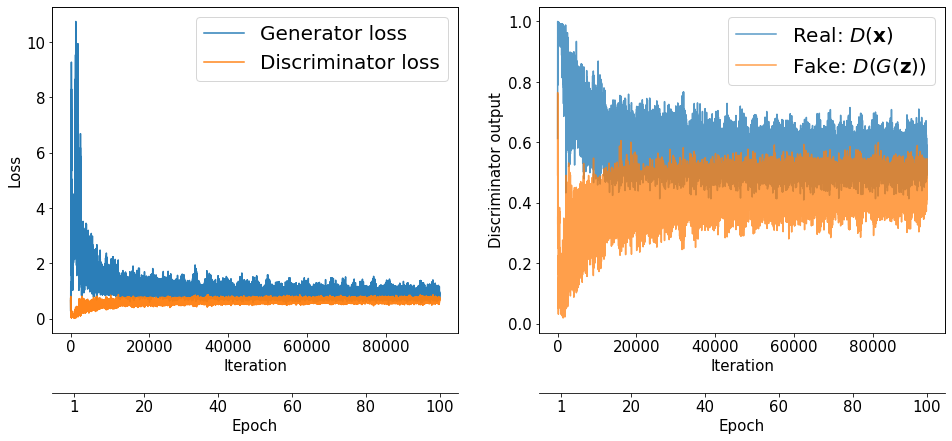

In [14]:
import itertools


fig = plt.figure(figsize=(16, 6))

## Plotting as perdas
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

## Plotting as saídas do discriminador
ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.show()

Observe que o modelo discriminador gera logits, mas para esta visualização, já armazenamos as probabilidades calculadas por meio da função sigmóide antes de calcular as médias para cada lote.

Como você pode ver nas saídas do discriminador na figura anterior, durante os estágios iniciais do treinamento, o discriminador foi capaz de aprender rapidamente a distinguir com bastante precisão entre os exemplos reais e falsos, ou seja, os exemplos falsos tinham probabilidades próximas a 0, e os exemplos reais tinham probabilidades próximas a 1. A razão para isso era que os exemplos falsos não eram nada parecidos com os reais; portanto, distinguir entre real e falso era bastante fácil. À medida que o treinamento avança, o gerador se tornará melhor em sintetizar imagens realistas, o que resultará em probabilidades de exemplos reais e falsos próximos a 0.5.

Além disso, também podemos ver como as saídas do gerador, ou seja, as imagens sintetizadas, mudam durante o treinamento. Após cada época, geramos alguns exemplos chamando a função `create_samples()` e os armazenamos em uma lista Python. No código a seguir, visualizaremos algumas das imagens produzidas pelo gerador para uma seleção de épocas:

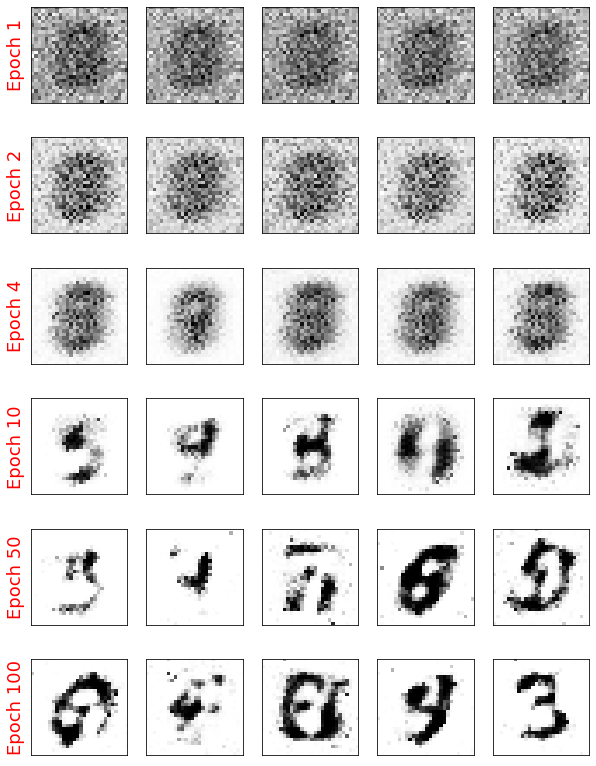

In [15]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
plt.show()

Como você pode ver na figura anterior, a rede geradora produziu imagens cada vez mais realistas à medida que o treinamento progredia. No entanto, mesmo após 100 épocas, as imagens produzidas ainda parecem muito diferentes dos dígitos manuscritos contidos no conjunto de dados MNIST.

Nesta seção, projetamos um modelo GAN muito simples com apenas uma única camada oculta totalmente conectada para o gerador e o discriminador. Após treinar o modelo GAN no conjunto de dados MNIST, conseguimos obter resultados promissores, embora ainda não satisfatórios, com os novos dígitos manuscritos. As arquiteturas NN com camadas convolucionais têm várias vantagens sobre as camadas totalmente conectadas quando se trata de classificação de imagens. De maneira semelhante, adicionar camadas convolucionais ao nosso modelo GAN para trabalhar com dados de imagem pode melhorar o resultado. Na próxima seção, implementaremos uma GAN convolucional profunda (DCGAN), que usa camadas convolucionais para as redes geradora e discriminadora.

### Melhorando a qualidade das imagens sintetizadas usando uma GAN convolucional e *Wasserstein*

Nesta seção, implementaremos um *DCGAN*, que nos permitirá melhorar o desempenho que vimos no exemplo anterior de GAN. Além disso, empregaremos várias técnicas extras e implementaremos um *Wasserstein GAN* (WGAN).

As técnicas que abordaremos nesta seção incluirão o seguinte:
• Convolução transposta
• Norma de lote (*BatchNorm*)
• WGAN
• Penalidade de gradiente (*Gradient Penalty*)

O *DCGAN* foi proposto em 2016 por A. Radford, L. Metz e S. Chintala em seu artigo Aprendizagem de representação não supervisionada com redes adversariais generativas convolucionais profundas, que está disponível gratuitamente em https://arxiv.org/pdf/1511.06434.pdf. Neste artigo, os pesquisadores propuseram o uso de camadas convolucionais para as redes geradora e discriminadora. A partir de um vetor aleatório, **z**, o *DCGAN* primeiro usa uma camada totalmente conectada para projetar **z** em um novo vetor com um tamanho adequado para que possa ser remodelado em uma representação de convolução espacial ($\small h \times w \times c$ ), que é menor que o tamanho da imagem de saída. Em seguida, uma série de camadas convolucionais, conhecidas como **convoluções transpostas**, são usadas para fazer o *upsample* dos mapas de *features* para o tamanho da imagem de saída desejado.

### Convolução transposta
Você já aprendeu sobre a operação de convolução em espaços unidimensionais e bidimensionais. Em particular, como as opções de preenchimento e passadas alteram os mapas de *features* de saída. Embora uma operação de convolução seja geralmente usada para reduzir a resolução do espaço de feição (por exemplo, definindo o passo para 2 ou adicionando uma camada de pool após uma camada convolucional), uma operação de **convolução transposta** geralmente é usada para aumentar a resolução do espaço de *feature*.

Para entender a operação de convolução transposta, vamos fazer um experimento de pensamento simples. Suponha que temos um mapa de *features* de entrada de tamanho $\small n \times n$. Em seguida, aplicamos uma operação de convolução 2D com certos parâmetros de preenchimento e passo a esta entrada $\small n \times n$, resultando em um mapa de *features* de saída de tamanho $\small m \times m$. Agora, a questão é, como podemos aplicar outra operação de convolução para obter um mapa de *features* com a dimensão inicial $\small n \times n$ deste mapa de *features* de saída $\small m \times m$ mantendo os padrões de conectividade entre a entrada e a saída? Observe que apenas a forma da matriz de entrada $\small n \times n$ é recuperada e não os valores reais da matriz. Isso é o que a convolução transposta faz, como mostrado na figura a seguir:

![](imagens\conv_transpose.PNG)



> ##### Convolução transposta versus deconvolução
> A convolução transposta também é chamada de **convolução fracionada**. Na literatura de aprendizado profundo, outro termo comum usado para se referir à convolução transposta é **deconvolução**. No entanto, observe que a deconvolução foi originalmente definida como o inverso de uma operação de convolução, $\small f$, em um mapa de *features*, **x**, com parâmetros de peso, **w**, produzindo o mapa de *features* $\small {x}'$, $f_w(x) = {x}'$. Uma função de deconvolução, $\small f^-1$, pode então ser definida como $f_w^{-1}(f(x)) = x$. No entanto, observe que a convolução transposta é meramente focada em recuperar a dimensionalidade do espaço de características e não os valores reais.

O *upsampling* de mapas de recursos usando convolução transposta funciona inserindo 0s entre os elementos dos mapas de recursos de entrada. A ilustração a seguir mostra um exemplo de aplicação de convolução transposta a uma entrada de tamanho $\small 4 \times 4$ , com um passo de $\small2 \times 2$ e tamanho de kernel de $\small 2 \times 2$. A matriz de tamanho $\small 9 \times 9$ no centro mostra os resultados após inserir esses 0s no mapa de recursos de entrada. Então, realizar uma convolução normal usando o kernel $\small 2 \times 2$ com um passo de 1 resulta em uma saída de tamanho $\small 8 \times 8$. Podemos verificar a direção para trás realizando uma convolução regular na saída com um passo de 2, o que resulta em um mapa de recursos de saída de tamanho $\small 4 \times 4$, que é o mesmo que o tamanho da entrada original:

![](imagens\conv_transpose2.PNG)

A ilustração anterior mostra como a convolução transposta funciona em geral. Existem vários casos em que o tamanho de entrada, tamanho do kernel, passos e variações de preenchimento podem alterar a saída. Se você quiser saber mais sobre todos esses diferentes casos, consulte o tutorial A Guide to Convolution Arithmetic for Deep Learning de Vincent Dumoulin e Francesco Visin, que está disponível gratuitamente em https://arxiv.org/pdf/1603.07285.pdf.

### Normalização em lote
**BatchNorm** foi introduzido em 2015 por Sergey Ioffe e Christian Szegedy no artigo Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift, que você pode acessar via arXiv em https://arxiv.org/pdf/1502.03167.pdf. Uma das principais ideias por trás do *BatchNorm* é normalizar as entradas da camada e evitar alterações em sua distribuição durante o treinamento, o que permite uma convergência mais rápida e melhor.

*BatchNorm* transforma um mini-lote de recursos com base em suas estatísticas computadas. Suponha que temos os mapas de recursos de pré-ativação líquida obtidos após uma camada convolucional em um tensor quadridimensional, **Z**, com a forma $\small [m \times h \times w \times c]$, onde $\small m$ é o número de exemplos no lote (ou seja, tamanho do lote), $\small h \times w$ é a dimensão espacial dos mapas de recursos e $\small c$ é o número de canais. O *BatchNorm* pode ser resumido em três etapas, como segue:

1. Calcule a média e o desvio padrão das entradas líquidas para cada minilote:

$$
\small \mu_B = \dfrac{1}{m \times h \times w}\sum Z^{[i,j,k,\dot]},\sigma^2_B = \dfrac{1}{m \times h \times w}\sum_{i,j,k} (Z^{[i,j,k,\dot]} - \mu_B)^2, \text{onde $\mu_B$  e $\sigma^2_B$ ambos tem o tamanho c}
$$

2. Padronize as entradas líquidas para todos os exemplos no lote:$\small Z^{[i]}_{std} = \dfrac{Z^{[i]}- \mu_B}{\sigma_B + \epsilon}$ onde $\small \epsilon$ é um número pequeno para estabilidade numérica (ou seja, para evitar a divisão por zero).

3. Dimensione e desloque as entradas líquidas normalizadas usando dois vetores de parâmetros que podem ser aprendidos, $\small \gamma$ e $\small \beta$, de tamanho $\small c$ (número de canais): $\small A_{pre}^{[i]} = \gamma Z^{[i]}_{std} + \beta$

A figura a seguir ilustra o processo:

![](imagens\batch_normalization.PNG)

Na primeira etapa de *BatchNorm*, a média, $\small \mu_B$, e o desvio padrão, $\small \sigma_B$, do mini-lote são calculados. Ambos $\small \mu_B$ e $\small \sigma_B$ são vetores de tamanho $\small c$ (onde $\small c$ é o número de canais). Em seguida, essas estatísticas são usadas na etapa 2 para dimensionar os exemplos em cada minilote por meio de normalização de pontuação $\small z$ (padronização), resultando em entradas líquidas padronizadas, $\small Z^{[i]}_{std}$. Como consequência, essas entradas líquidas são centradas na média e têm variância unitária, que geralmente é uma propriedade útil para otimização baseada em gradiente descendente. Por outro lado, sempre normalizar as entradas da rede de forma que tenham as mesmas propriedades nos diferentes mini-lotes, que podem ser diversos, pode impactar severamente a capacidade de representação das RNs. Isso pode ser entendido considerando um recurso, $\small x \sim N(0,1)$, que, após a ativação do sigmóide para $\small \sigma(x)$, resulta em uma região linear para valores próximos a 0. Portanto, na etapa 3, os parâmetros apreensíveis, $\small \beta$ e $\small \gamma$, que são vetores de tamanho $\small c$ (número de canais), permitem que *BatchNorm* controle o deslocamento e a propagação dos recursos normalizados.

Durante o treinamento, as médias de corrida, $\small \mu_B$, e a variância de corrida, $\small \sigma_B^2$, são calculadas, que são usadas junto com os parâmetros ajustados, $\small \beta$ e $\small \gamma$, para normalizar o(s) exemplo(s) de teste na avaliação.

> ##### Por que o *BatchNorm* ajuda na otimização?
> Inicialmente, o *BatchNorm* foi desenvolvido para reduzir o chamado **deslocamento de covariância interna**, que é definido como as mudanças que ocorrem na distribuição das ativações de uma camada devido à atualização dos parâmetros da rede durante o treinamento.
> Para explicar isso com um exemplo simples, considere um lote fixo que passa pela rede na época 1. Registramos as ativações de cada camada para esse lote. Após iterar por todo o conjunto de dados de treinamento e atualizar os parâmetros do modelo, iniciamos a segunda época, onde o lote previamente fixado passa pela rede. Em seguida, comparamos a camada de ativações da primeira e segunda épocas. Como os parâmetros da rede mudaram, observamos que as ativações também mudaram. Esse fenômeno é chamado de mudança de covariância interna, que se acreditava desacelerar o treinamento do NN.
> No entanto, em 2018, S. Santurkar, D. Tsipras, A. Ilyas e A. Madry investigaram ainda mais o que torna o *BatchNorm* tão eficaz. Em seus estudos, os pesquisadores observaram que o efeito do *BatchNorm* na mudança de covariância interna é marginal. Com base no resultado de seus experimentos, eles levantaram a hipótese de que a eficácia do *BatchNorm* é, em vez disso, baseada em uma superfície mais suave da função de perda, o que torna a otimização não convexa mais robusta.
> Se você estiver interessado em aprender mais sobre esses resultados, leia o artigo original, How Does Batch Normalization Help Optimization?, que está disponível gratuitamente em http://papers.nips.cc/paper/7515-how-does-batch-normalization-help-optimization.pdf.

A API *TensorFlow* Keras fornece uma classe, `tf.keras.layers.BatchNormalization()`, que podemos usar como camada ao definir nossos modelos; ele executará todas as etapas que descrevemos para *BatchNorm*. Observe que o comportamento para atualizar os parâmetros aprendíveis, $\small \gamma$ e $\small \beta$, depende se `training=False` ou `training=True`, que pode ser usado para garantir que esses parâmetros sejam aprendidos apenas durante o treinamento.

#### Implementando o gerador e o discriminador
Neste ponto, cobrimos os principais componentes de um modelo DCGAN, que agora iremos implementar. As arquiteturas das redes geradoras e discriminadoras estão resumidas nas duas figuras a seguir. O gerador recebe um vetor, **z**, de tamanho 20 como entrada, aplica uma camada totalmente conectada (densa) para aumentar seu tamanho para 6.272 e, em seguida, o remodela em um tensor de nível 3 de forma $\small 7 \times 7 \times 128$ (dimensão espacial $\small 7 \times 7 \times 128$ canais). Em seguida, uma série de convoluções transpostas usando `tf.keras.layers.Conv2DTransposed()` faz o *upsample* dos mapas de *features* até que a dimensão espacial dos mapas de recursos resultantes atinja $\small 28 \times 28$. O número de canais é reduzido pela metade após cada camada convolucional transposta, exceto a última, que utiliza apenas um filtro de saída para gerar uma imagem em tons de cinza. Cada camada convolucional transposta é seguida pelas funções de ativação *BatchNorm* e *leaky ReLU*, exceto a última, que usa ativação *tanh* (sem *BatchNorm*). A arquitetura do gerador (os mapas de *features* após cada camada) é mostrada na figura a seguir:

![](imagens\generator_network.PNG)


O discriminador recebe imagens de tamanho $\small 28 \times 28 \times 1$, que são passadas por quatro camadas convolucionais. As três primeiras camadas convolucionais reduzem a dimensionalidade espacial em 4, enquanto aumentam o número de canais dos mapas de *fesatures*. Cada camada convolucional também é seguida por *BatchNorm*, ativação de *leaky ReLU* e uma camada de *dropout* com `rate = 0.3` (probabilidade de queda). A última camada convolucional usa kernels de tamanho $\small 7 \times 7$ e um único filtro para reduzir a dimensionalidade espacial da saída para $\small 1 \times 1 \times 1$.

![](imagens\discriminator_network.PNG)

> ##### Considerações de projeto de arquitetura para GANs convolucionais
> Observe que o número de mapas de características segue tendências diferentes entre o gerador e o discriminador. No gerador, começamos com um grande número de mapas de recursos e os reduzimos à medida que avançamos para a última camada. Por outro lado, no discriminador, começamos com um pequeno número de canais e aumentamos em direção à última camada. Este é um ponto importante para projetar CNNs com o número de mapas de recursos e o tamanho espacial dos mapas de recursos em ordem inversa. Quando o tamanho espacial dos mapas de recursos aumenta, o número de mapas de recursos diminui e vice-versa.
> Além disso, observe que geralmente não é recomendado usar unidades de polarização na camada que segue uma camada *BatchNorm*. Usar unidades de polarização seria redundante neste caso, pois *BatchNorm* já possui um parâmetro de deslocamento, $\small \beta$. Você pode omitir as unidades de polarização para uma determinada camada configurando `use_bias=False` em `tf.keras.layers.Dense` ou `tf.keras.layers.Conv2D`.

O código para duas funções auxiliares para fazer as redes geradora e discriminadora é o seguinte:

In [16]:
def make_dcgan_generator(
        z_size=20, 
        output_size=(28, 28, 1),
        n_filters=128, 
        n_blocks=2):
    size_factor = 2**n_blocks
    hidden_size = (
        output_size[0]//size_factor, 
        output_size[1]//size_factor
    )
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(z_size,)),
        
        tf.keras.layers.Dense(
            units=n_filters*np.prod(hidden_size), 
            use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape(
            (hidden_size[0], hidden_size[1], n_filters)),
    
        tf.keras.layers.Conv2DTranspose(
            filters=n_filters, kernel_size=(5, 5), strides=(1, 1),
            padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
        
    nf = n_filters
    for i in range(n_blocks):
        nf = nf // 2
        model.add(
            tf.keras.layers.Conv2DTranspose(
                filters=nf, kernel_size=(5, 5), strides=(2, 2),
                padding='same', use_bias=False))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
                
    model.add(
        tf.keras.layers.Conv2DTranspose(
            filters=output_size[2], kernel_size=(5, 5), 
            strides=(1, 1), padding='same', use_bias=False, 
            activation='tanh'))
        
    return model

def make_dcgan_discriminator(
        input_size=(28, 28, 1),
        n_filters=64, 
        n_blocks=2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_size),
        tf.keras.layers.Conv2D(
            filters=n_filters, kernel_size=5, 
            strides=(1, 1), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
    
    nf = n_filters
    for i in range(n_blocks):
        nf = nf*2
        model.add(
            tf.keras.layers.Conv2D(
                filters=nf, kernel_size=(5, 5), 
                strides=(2, 2),padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.3))
        
    model.add(tf.keras.layers.Conv2D(
            filters=1, kernel_size=(7, 7), padding='valid'))
    
    model.add(tf.keras.layers.Reshape((1,)))
    
    return model

Com essas duas funções auxiliares, você pode construir um modelo *DCGAN* e treiná-lo usando o mesmo objeto de conjunto de dados MNIST que inicializamos na seção anterior quando implementamos o GAN simples e totalmente conectado. Além disso, podemos usar as mesmas funções de perda e procedimento de treinamento de antes.

Faremos algumas modificações adicionais no modelo *DCGAN* nas seções restantes. Observe que a função `preprocess()` para transformar o conjunto de dados deve ser alterada para gerar um tensor de imagem em vez de achatar a imagem em um vetor. O código a seguir mostra as modificações necessárias para construir o dataset, bem como criar as novas redes geradoras e discriminadoras:

In [17]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image*2 - 1.0
    if mode == 'uniform':
        input_z = tf.random.uniform(
            shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image

Podemos criar as redes geradoras usando a função auxiliar, `make_dcgan_generator()`, e imprimir sua arquitetura da seguinte forma:

In [18]:
gen_model = make_dcgan_generator()
gen_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 6272)              125440    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        409600    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)       

Da mesma forma, podemos gerar a rede discriminadora e ver sua arquitetura:

In [19]:
disc_model = make_dcgan_discriminator()
disc_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       204928    
                                                                 
 batch_normalization_5 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 14, 14, 128)      

Observe que o número de parâmetros para as camadas *BatchNorm* é de fato quatro vezes o número de canais ($\small 4 \times channels$). Lembre-se que os parâmetros *BatchNorm*, $\small \mu_B$ e $\small \sigma_B$, representam a média (parâmetros não treináveis) e o desvio padrão para cada valor de recurso inferido de um determinado lote; $\small\gamma$ e $\small \beta$ são os parâmetros BN treináveis.

Observe que essa arquitetura específica não funcionaria muito bem ao usar **entropia cruzada** como uma função de perda.

Na próxima subseção, abordaremos o WGAN, que usa uma função de perda modificada baseada na chamada distância de *Wasserstein-1* (ou terra) entre as distribuições de imagens reais e falsas para melhorar o desempenho do treinamento.

### Medidas de dissimilaridade entre duas distribuições

Veremos primeiro medidas diferentes para calcular a divergência entre duas distribuições. Em seguida, veremos qual dessas medidas já está incorporada no modelo GAN original. Por fim, a mudança dessa medida em GANs nos levará à implementação de um WGAN. Conforme mencionado no início, o objetivo de um modelo generativo é aprender a sintetizar novas amostras que tenham a mesma distribuição que a distribuição do conjunto de dados de treinamento. Seja $\small P(x)$ e $\small Q(x)$ a distribuição de uma variável aleatória, **x**, conforme mostrado na figura a seguir.

Primeiro, vamos ver algumas maneiras, mostradas na figura a seguir, que podemos usar para medir a dissimilaridade entre duas distribuições, *P* e *Q*:


![](imagens\dissimilaridade.PNG)



A função supremum, $\small sup(S)$, usada na medida de variação total (TV), refere-se ao menor valor que é maior que todos os elementos de $\small S$. Em outras palavras, $\small sup(S)$ é o menor limite superior para $\small S$. Vice inversamente, a função ínfima, $\small inf(S)$, que é usada na distância EM, refere-se ao maior valor que é menor que todos os elementos de $\small S$ (o maior limite inferior). Vamos entender essas medidas afirmando brevemente o que elas estão tentando realizar em palavras simples:
* A primeira, distância de TV, mede a maior diferença entre as duas distribuições em cada ponto.
* A distância EM pode ser interpretada como a quantidade mínima de trabalho necessária para transformar uma distribuição na outra. A função ínfima na distância EM é assumida $\small \prod(P,Q)$, que é a coleção de todas as distribuições conjuntas cujos marginais são $\small P$ ou $\small Q$. Então, $\small \gamma (u,v)$ é um plano de transferência, que indica como redistribuímos a terra do local $\small u$ para $\small v$, sujeito a algumas restrições para manter distribuições válidas após tais transferências. Calcular a distância EM é um problema de otimização por si só, que é encontrar o plano de transferência ótimo, $\small \gamma (u,v)$.
* As medidas de divergência de Kullback-Leibler (KL) e Jensen-Shannon (JS) são oriundas do campo da teoria da informação. Observe que a divergência KL não é simétrica, ou seja, $\small KL(P\parallel Q) \neq KL(Q \parallel P)$  em contraste com a divergência JS.

As equações de dissimilaridade fornecidas na figura anterior correspondem a distribuições contínuas, mas podem ser estendidas para casos discretos. Um exemplo de cálculo dessas diferentes medidas de dissimilaridade com duas distribuições discretas simples é ilustrado na figura a seguir:

![](imagens\dissimilaridade_medidas.PNG)


Observe que, no caso da distância EM, para este exemplo simples, podemos ver que $\small Q(x)$ em $\small x = 2$ tem o valor excedente de $\small 0.5 − \dfrac{1}{3} = 0.166$, enquanto o valor de $\small Q$ nos outros dois $\small x's$ está abaixo de 1/3. Portanto, a quantidade mínima de trabalho é quando transferimos o valor extra em $\small x = 2$ para $\small x = 1$ e $\small x = 3$, conforme mostrado na figura anterior. Para este exemplo simples, é fácil ver que essas transferências resultarão na quantidade mínima de trabalho de todas as transferências possíveis. No entanto, isso pode ser inviável para casos mais complexos.






> ##### A relação entre divergência KL e entropia cruzada
> A divergência $\small KL$, $\small KL(P \parallel Q)$, mede a entropia relativa da distribuição, $\small P$, em relação a uma distribuição de referência,$\small Q$. A formulação para a divergência de $\small KL$ pode ser estendida como
> 
> $$
> \small KL(P \parallel Q) = - \int P(x) log(Q(x))dx - \left ( \int P(x)log(P(x)) \right ) 
> $$
> 
> Além disso, para distribuições discretas, a divergência KL pode ser escrita como
> 
> $$
> \small KL(P \parallel Q) = - \sum_i P(x_i)\dfrac{P(x_i)}{Q(x_i)}
> $$
> 
> que pode ser igualmente estendido como 
> $$
> \small KL(P \parallel Q) = - \sum_i P(x_i)log(Q(x_i)) - \left ( -\sum_i P(x_i)log(P(x_i))\right )
> $$
> 
> Com base na formulação estendida (discreta ou contínua), a divergência $\small KL$ é vista como a entropia cruzada entre $\small P$ e $\small Q$ (o primeiro termo na equação anterior) subtraída pela (self-) entropia de $\small P$ (segundo termo), que é, $\small KL(P \parallel Q) = H(P,Q) - H(P)$.

Agora, voltando à nossa discussão sobre GANs, vamos ver como essas diferentes medidas de distância estão relacionadas à função de perda para GANs. Pode ser demonstrado matematicamente que a função de perda no GAN original de fato minimiza a divergência JS entre a distribuição de exemplos reais e falsos. Mas, como discutido em um artigo de Martin Arjovsky et al. (Wasserstein Generative Adversarial Networks, http://proces.mlr.press/v70/arjovsky17a/arjovsky17a.pdf), a divergência JS tem problemas para treinar um modelo GAN e, portanto, para melhorar o treinamento, os pesquisadores propuseram usar o EM distância como medida de dissimilaridade entre a distribuição de exemplos reais e falsos.

> ##### Qual é a vantagem de usar a distância EM?
> Para responder a esta pergunta, podemos considerar um exemplo que foi dado no artigo de Martin Arjovsky et al, intitulado Wasserstein GAN. Para colocar em palavras simples, suponha que temos duas distribuições, $\small P$ e $\small Q$, que são duas linhas paralelas. Uma linha é fixa em $\small x = 0$ e a outra linha pode se mover pelo eixo $\small x$, mas está inicialmente localizada em $\small x = \theta$ , onde $\small \theta > 0$.
> 
> Pode-se mostrar que as medidas de dissimilaridade $\small KL$, $\small TV$ e $\small JS$ são  $\small KL(P \parallel Q) = + \infty, TV (P,Q) = 1$, e $\small JS(P,Q) = \dfrac{1}{2}log2$. Nenhuma dessas medidas de dissimilaridade é uma função do parâmetro $\small \theta$ e, portanto, elas não podem ser diferenciadas em relação a $\small \theta$ para tornar as distribuições, $\small P$ e $\small Q$, semelhantes entre si. Por outro lado, a distância EM é $\small EM(P,Q) = \left | \theta \right |$, cujo gradiente em relação a $\small \theta$ existe e pode empurrar $\small Q$ em direção a $\small P$.



Agora, vamos focar nossa atenção em como a distância EM pode ser usada para treinar um modelo GAN. Vamos supor que $\small P_r$ é a distribuição dos exemplos reais e $\small P_g$ denota as distribuições de exemplos falsos (gerados). $\small P$ e $\small P_g$ substituem $\small P$ e $\small Q$ na equação de distância EM. Como foi mencionado anteriormente, calcular a distância EM é um problema de otimização por si só; portanto, isso se torna computacionalmente intratável, especialmente se quisermos repetir essa computação em cada iteração do loop de treinamento GAN. Felizmente, porém, o cálculo da distância EM pode ser simplificado usando um teorema chamado `dualidade de Kantorovich-Rubinstein`, como segue:
$$
\small W(P_r,P_g) = \underset{\left \| f \right \|_L \leq 1}{sup} E_{u \in P_r}[f(u)] - E_{v \in P_g}[f(v)]
$$

Aqui, o supremo é tomado sobre todas as funções contínuas de *1-Lipschitz* denotadas por $\small \left \| f \right \|_L \leq 1$.

> ##### Continuidade de Lipschitz
> Com base na continuidade de *1-Lipschitz*, a função,$\small f$, deve satisfazer a seguinte propriedade:
$$
\small \left | f(x_1) - f(x_2) \right | \leq  \left | x_1 - x_2 \right |
$$


Além disso, uma função real, $\small f: R \rightarrow R$, que satisfaz a propriedade 
$$
\small \left | f(x_1) - f(x_2) \right | \leq K\left | x_1 - x_2 \right |
$$
é chamado de K-Lipschitz contínuo.


### Usando a distância EM na prática para GANs
Agora, a questão é, como encontramos uma função contínua de *1-Lipschitz* para calcular a distância de *Wasserstein* entre a distribuição de saídas reais ($\small P_r$) e falsas ($\small P_g$) para uma GAN? Embora os conceitos teóricos por trás da abordagem WGAN possam parecer complicados à primeira vista, a resposta a essa pergunta é mais simples do que parece. Lembre-se de que consideramos NNs profundos como aproximadores de funções universais. Isso significa que podemos simplesmente treinar um modelo NN para aproximar a função de distância de *Wasserstein*. Como você viu na seção anterior, o GAN simples usa um discriminador na forma de um classificador. Para WGAN, o discriminador pode ser alterado para se comportar como um crítico, que retorna uma pontuação escalar em vez de um valor de probabilidade. Podemos interpretar essa partitura como realistas as imagens de entrada (como um crítico de arte dando partituras para obras de arte em uma galeria).

Para treinar um GAN usando a distância de *Wasserstein*, as perdas para o discriminador, $\small D$, e o gerador, $\small G$, são definidas como segue. O crítico (ou seja, a rede discriminadora) retorna suas saídas para o lote de exemplos de imagens reais e o lote de exemplos sintetizados. Usamos as notações $\small D(x)$ e $\small D(G(z))$, respectivamente. Então, os seguintes termos de perda podem ser definidos:

* O componente real da perda do discriminador: $\small L^D_{real} = -\dfrac{1}{N}\sum_iD(x_i)$
• O componente falso da perda do discriminador: $\small L^D_{fake} = \dfrac{1}{N}\sum_iD(G(z_i))$
• A perda para o gerador: $ \small L^G = - \dfrac{1}{N}\sum_iD(G(z_i))$

Isso será tudo para o WGAN, exceto que precisamos garantir que a propriedade *1-Lipschitz* da função crítica seja preservada durante o treinamento. Para este propósito, o artigo WGAN propõe fixar os pesos em uma pequena região, por exemplo, [–0.01, 0.01].


### Penalidade de gradiente
No artigo de Arjovsky et al., o recorte de peso é sugerido para a propriedade *1-Lipschitz* do discriminador (ou crítico). No entanto, em outro artigo intitulado Improved Training of *Wasserstein* GANs, que está disponível gratuitamente em https://arxiv.org/pdf/1704.00028.pdf, Ishaan Gulrajani et al. mostrou que cortar os pesos pode levar **à explosão e desaparecimento de gradientes**. Além disso, o corte de peso também pode levar à subutilização da capacidade, o que significa que a rede crítica está limitada a aprender apenas algumas funções simples, em oposição a funções mais complexas. Portanto, em vez de cortar os pesos, Ishaan Guljarani et al. propôs **a penalidade de gradiente** (GP) como uma solução alternativa. O resultado é o **WGAN com penalidade de gradiente (WGAN-GP)**. O procedimento para o GP que é adicionado em cada iteração pode ser resumido pela seguinte sequência de etapas:

1. Para cada par de exemplos reais e falsos ($ \small x^{[i]}, \tilde{x}^{[i]}$) em um determinado lote, escolha um número aleatório, $\small \alpha^{[i]}$, amostrado de uma distribuição uniforme, ou seja, $\small \alpha^{[i]} \in U(0,1)$.
2. Calcule uma interpolação entre os exemplos reais e falsos: $\small \check{x}^{[i]} = \alpha x^{[i]} +(1 - \alpha)\tilde{x}^{[i]}$ , resultando em um lote de exemplos interpolados.
3. Calcule a saída do discriminador (crítico) para todos os exemplos interpolados, $ \small D(\check{x}^{[i]}) $)
4. Calcule os gradientes da saída do crítico em relação a cada exemplo interpolado, ou seja, $\small \bigtriangledown_{\check{x}^{[i]}}D(\check{x}^{[i]})$.
5. Calcule o GP como $\small L^{D}_{gp} = \dfrac{1}{N}\sum_i\left ( \left \| \triangledown_{\check{x}^{[i]}} \right \|_2 - 1 \right )^2 $

A perda total para o discriminador é então a seguinte:
$$
\small L^{D}_{total} = L^{D}_{real} + L^D_{fake} + \gamma L^D_{gp}
$$
Aqui, $\small \gamma$ é um hiperparâmetro ajustável.

### Implementando WGAN-GP para treinar o modelo DCGAN
Já definimos as funções auxiliares que criam as redes geradoras e discriminadoras para DCGAN (`make_dcgan_generator()` e `make_dcgan_discriminator()`). O código para construir o modelo DCGAN é o seguinte:

In [20]:
num_epochs = 100
batch_size = 128
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
lambda_gp = 10.0

tf.random.set_seed(1)
np.random.seed(1)

## Set-up the dataset
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## Set-up the model
with tf.device(device_name):
    gen_model = make_dcgan_generator()
    gen_model.build(input_shape=(None, z_size))
    gen_model.summary()

    disc_model = make_dcgan_discriminator()
    disc_model.build(input_shape=(None, np.prod(image_size)))
    disc_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 6272)              125440    
                                                                 
 batch_normalization_7 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 7, 7, 128)        409600    
 ranspose)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 7, 7, 128)       

Agora podemos treinar o modelo. Observe que, normalmente, o otimizador RMSprop é recomendado para WGAN (sem o GP), enquanto o otimizador Adam é usado para WGAN-GP. O código é o seguinte:

In [21]:
import time


## optimizers:
g_optimizer = tf.keras.optimizers.Adam(0.0002)
d_optimizer = tf.keras.optimizers.Adam(0.0002)

if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))

def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

all_losses = []
epoch_samples = []

start_time = time.time()

for epoch in range(1, num_epochs+1):
    epoch_losses = []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        ## Compute discriminator's loss and gradients:
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            g_output = gen_model(input_z, training=True)
            
            d_critics_real = disc_model(input_real, training=True)
            d_critics_fake = disc_model(g_output, training=True)

            ## Compute generator's loss:
            g_loss = -tf.math.reduce_mean(d_critics_fake)

            ## Compute discriminator's losses
            d_loss_real = -tf.math.reduce_mean(d_critics_real)
            d_loss_fake =  tf.math.reduce_mean(d_critics_fake)
            d_loss = d_loss_real + d_loss_fake

            ## Gradient penalty:
            with tf.GradientTape() as gp_tape:
                alpha = tf.random.uniform(
                    shape=[d_critics_real.shape[0], 1, 1, 1], 
                    minval=0.0, maxval=1.0)
                interpolated = (
                    alpha*input_real + (1-alpha)*g_output)
                gp_tape.watch(interpolated)
                d_critics_intp = disc_model(interpolated)
            
            grads_intp = gp_tape.gradient(
                d_critics_intp, [interpolated,])[0]
            grads_intp_l2 = tf.sqrt(
                tf.reduce_sum(tf.square(grads_intp), axis=[1, 2, 3]))
            grad_penalty = tf.reduce_mean(tf.square(grads_intp_l2 - 1.0))
        
            d_loss = d_loss + lambda_gp*grad_penalty
        
        ## Optimization: Compute the gradients apply them
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
        
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
                    
    all_losses.append(epoch_losses)
    
    print('Epoch {:-3d} | ET {:.2f} min | Avg Losses >>'
          ' G/D {:6.2f}/{:6.2f} [D-Real: {:6.2f} D-Fake: {:6.2f}]'
          .format(epoch, (time.time() - start_time)/60, 
                  *list(np.mean(all_losses[-1], axis=0)))
    )
    
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy()
    )

Epoch   1 | ET 3.70 min | Avg Losses >> G/D 190.60/-316.95 [D-Real: -207.78 D-Fake: -190.60]
Epoch   2 | ET 7.36 min | Avg Losses >> G/D 140.58/-87.08 [D-Real: -92.36 D-Fake: -140.58]
Epoch   3 | ET 11.02 min | Avg Losses >> G/D  78.68/ -1.07 [D-Real: -12.46 D-Fake: -78.68]
Epoch   4 | ET 14.70 min | Avg Losses >> G/D  40.61/ -6.44 [D-Real:  -8.48 D-Fake: -40.61]
Epoch   5 | ET 18.37 min | Avg Losses >> G/D  46.44/-19.73 [D-Real:  -5.06 D-Fake: -46.44]
Epoch   6 | ET 22.05 min | Avg Losses >> G/D  47.56/-15.69 [D-Real:   2.23 D-Fake: -47.56]
Epoch   7 | ET 25.73 min | Avg Losses >> G/D  36.42/-15.03 [D-Real:   0.70 D-Fake: -36.42]
Epoch   8 | ET 29.39 min | Avg Losses >> G/D  50.07/-14.99 [D-Real:  28.14 D-Fake: -50.07]
Epoch   9 | ET 33.07 min | Avg Losses >> G/D  48.70/-21.54 [D-Real:  23.81 D-Fake: -48.70]
Epoch  10 | ET 36.74 min | Avg Losses >> G/D  45.31/-22.48 [D-Real:  15.02 D-Fake: -45.31]
Epoch  11 | ET 40.42 min | Avg Losses >> G/D  68.52/-33.22 [D-Real:  28.36 D-Fake: -68.5

Por fim, vamos visualizar os exemplos salvos em algumas épocas para ver como o modelo está aprendendo e como a qualidade dos exemplos sintetizados muda ao longo do aprendizado:

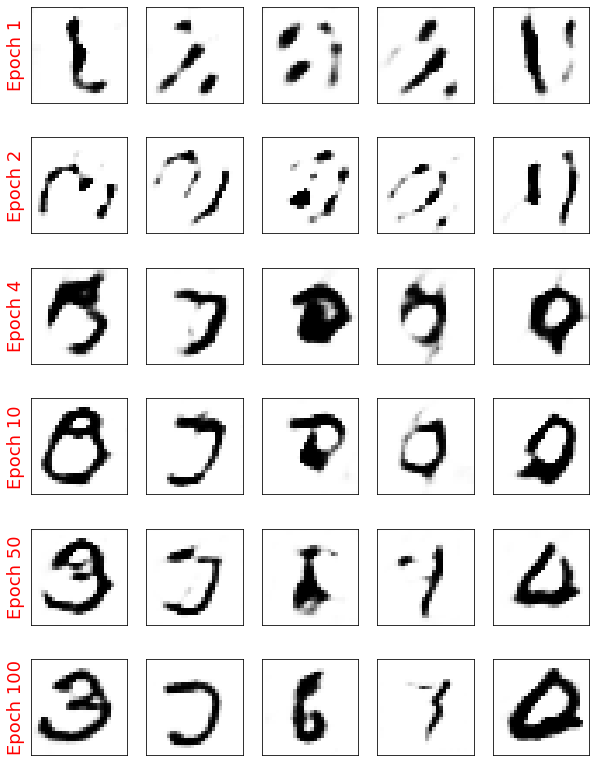

In [22]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
plt.show()

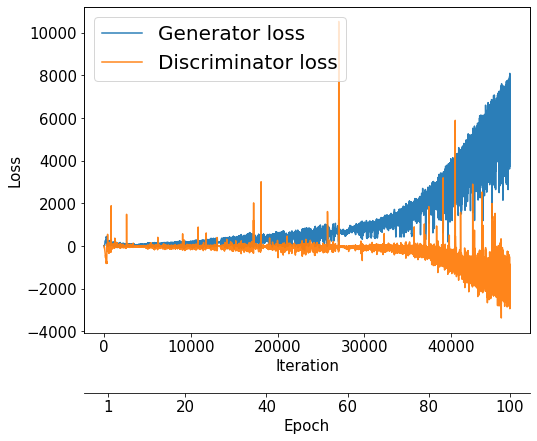

In [23]:
import itertools


fig = plt.figure(figsize=(8, 6))

## Plotting as perdas
ax = fig.add_subplot(1, 1, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1] for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos   = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.show()

Usamos o mesmo código para visualizar os resultados da seção sobre o vanilla GAN. A comparação dos novos exemplos mostra que o DCGAN (com Wasserstein e GP) pode gerar imagens de qualidade muito superior.

### Colapso de Modo
Devido à natureza contraditória dos modelos GAN, é notoriamente difícil treiná-los. Uma causa comum de falha no treinamento de GANs é quando o gerador fica preso em um pequeno subespaço e aprende a gerar amostras semelhantes. Isso é chamado de **colapso de modo** e um exemplo é mostrado na figura a seguir.

Os exemplos sintetizados nesta figura não são escolhidos a dedo. Isso mostra que o gerador falhou em aprender toda a distribuição de dados e, em vez disso, adotou uma abordagem preguiçosa com foco em um subespaço:

![](imagens\colapso_modo.PNG)

Além dos problemas de gradiente de fuga e explosão que vimos anteriormente, existem alguns outros aspectos que também podem dificultar o treinamento de modelos GAN (na verdade, é uma arte). Aqui estão alguns truques sugeridos por artistas da GAN.

Uma abordagem é chamada de **discriminação de mini-lote**, que se baseia no fato de que lotes consistindo apenas de exemplos reais ou falsos são alimentados separadamente ao discriminador. Na discriminação de minilote, deixamos o discriminador comparar exemplos nesses lotes para ver se um lote é real ou falso. A diversidade de um lote consistindo apenas de exemplos reais é provavelmente maior do que a diversidade de um lote falso se um modelo sofrer de colapso de modo.

Outra técnica que é comumente usada para estabilizar o treinamento de GAN é a correspondência de recursos. No casamento de características, fazemos uma pequena modificação na função objetivo do gerador adicionando um termo extra que minimiza a diferença entre as imagens originais e sintetizadas com base em representações intermediárias (mapas de características) do discriminador. Incentivamos você a ler mais sobre essa técnica no artigo original de Ting-Chun Wang et al., intitulado High Resolution Image Synthesis and Semantic Manipulation with Conditional GANs, que está disponível gratuitamente em https://arxiv.org/pdf/1711.11585.pdf.

Durante o treinamento, um modelo GAN também pode ficar preso em vários modos e apenas pular entre eles. Para evitar esse comportamento, você pode armazenar alguns exemplos antigos e alimentá-los ao discriminador para evitar que o gerador revisite os modos anteriores. Essa técnica é chamada de *repetição de experiência*. Além disso, você pode treinar vários GANs com diferentes sementes aleatórias para que a combinação de todos eles cubra uma parte maior da distribuição de dados do que qualquer um deles.

### Outros aplicações de GAN
Até agora, focamos principalmente na geração de exemplos usando GANs e analisamos alguns truques e técnicas para melhorar a qualidade das saídas sintetizadas. As aplicações de GANs estão se expandindo rapidamente, inclusive em visão computacional, aprendizado de máquina e até mesmo em outros domínios da ciência e da engenharia. Uma boa lista de diferentes modelos de GAN e áreas de aplicação pode ser encontrada em https://github.com/hindupuravinash/the-gan-zoo.

Vale ressaltar que abordamos GANs de forma não supervisionada, ou seja, nenhuma informação de rótulo de classe foi usada nos modelos abordados. No entanto, a abordagem GAN também pode ser generalizada para tarefas semi-supervisionadas e supervisionadas. Por exemplo, o GAN condicional (cGAN) proposto por Mehdi Mirza e Simon Osindero no artigo Conditional Generative Adversarial Nets (https://arxiv.org/pdf/1411.1784.pdf) usa as informações do rótulo da classe e aprende a sintetizar novas imagens condicionadas no rótulo fornecido, ou seja,$ \small \tilde{x} = G(z|y)  $ — aplicado ao MNIST. Isso nos permite gerar diferentes dígitos no intervalo de 0 a 9 de forma seletiva. Além disso, GANs condicionais nos permitem fazer a tradução de imagem para imagem, que é aprender como converter uma determinada imagem de um domínio específico para outro. Neste contexto, um trabalho interessante é o algoritmo Pix2Pix, publicado no artigo Image-to-Image Translation with Conditional Adversarial Networks de Philip Isola et al. (https://arxiv.org/pdf/1611.07004.pdf). Vale a pena mencionar que no algoritmo Pix2Pix, o discriminador fornece as previsões reais/falsas para vários patches na imagem, em oposição a uma única previsão para uma imagem inteira.

CycleGAN é outro modelo de GAN interessante construído em cima do cGAN, também para tradução de imagem para imagem. No entanto, observe que no CycleGAN, os exemplos de treinamento dos dois domínios não são pareados, o que significa que não há correspondência um-para-um entre entradas e saídas. Por exemplo, usando um CycleGAN, podemos mudar a estação de uma foto tirada no verão para o inverno. No artigo Unpaired Image-to-Image Translation Using Cycle-Consistent Adversarial Networks de Jun-Yan Zhu et al. (https://arxiv.org/pdf/1703.10593.pdf), um exemplo impressionante mostra cavalos convertidos em zebras.